In [4]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
PATH = "./Data/FER2013"

trainDir = os.path.join(PATH, 'train')
testDir = os.path.join(PATH, 'test')
valDir = os.path.join(PATH, "validation")

In [6]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224) # MobileNetV2 requires these dims

In [7]:
trainingDataSet = tf.keras.utils.image_dataset_from_directory(trainDir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
testingDataSet = tf.keras.utils.image_dataset_from_directory(testDir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
valDataSet = tf.keras.utils.image_dataset_from_directory(valDir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.
Found 3141 files belonging to 7 classes.


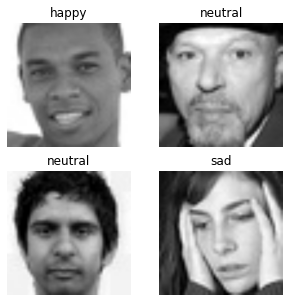

In [8]:
classNames = trainingDataSet.class_names

plt.figure(figsize=(5,5))
for images, labels in trainingDataSet.take(1):
    for i in range(4):
        ax = plt.subplot(2,2, i+ 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classNames[labels[i]])
        plt.axis("off")


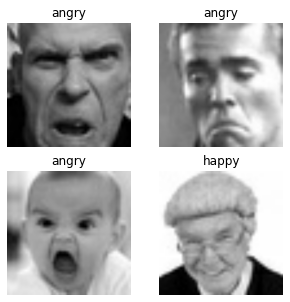

In [9]:
plt.figure(figsize=(5,5))
for images, labels in valDataSet.take(1):
    for i in range(4):
        ax = plt.subplot(2,2, i+ 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classNames[labels[i]])
        plt.axis("off")

In [73]:
def process(image,label):
    image = tf.cast(image/255. ,tf.float64)
    return image,label


testingDataSet = testingDataSet.map(process)
# trainingDataSet = trainingDataSet.map(process)
valDataSet = valDataSet.map(process)

In [44]:
#Buffered prefetching to help performance
autotune = tf.data.AUTOTUNE

trainingDataSet = trainingDataSet.prefetch(buffer_size=autotune)
testingDataSet = testingDataSet.prefetch(buffer_size=autotune)
valDataSet = valDataSet.prefetch(buffer_size=autotune)

In [45]:
#Rescale pixel values
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
preprocess_input

<function keras.applications.mobilenet_v2.preprocess_input(x, data_format=None)>

In [46]:
#Download pre-trained model
baseModel = tf.keras.applications.MobileNetV2()

In [47]:
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [48]:
#convert image to blocks of features
image_batch, label_batch = next(iter(trainingDataSet))
feature_batch = baseModel(image_batch)
print(feature_batch.shape)

(32, 1000)


In [49]:
# baseModel.trainable = False

In [50]:

base_input = baseModel.layers[0].input
# base_input = preprocess_input() #Normalize the inputs

base_output = baseModel.layers[-2].output

final_output = layers.Dense(128)(base_output) #add new layer after output of global pooling layer
final_output = layers.Activation('relu')(final_output) #activation function
final_output = layers.Dropout(0.3)(final_output)     #****
final_output = layers.Dense(64)(final_output)
final_output = layers.Activation('sigmoid')(final_output)
final_output = layers.Dropout(0.3)(final_output) 
final_output = layers.Dense(7, activation='softmax')(final_output) #classification layer


model = keras.Model(inputs =  base_input, outputs = final_output)



In [51]:
base_learning_rate = 0.000001
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [52]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [53]:
len(model.trainable_variables)

162

In [54]:
# #Initial loss/Accuracy
# loss0, accuracy0 = model.evaluate(valDataSet)

In [55]:

model0 = model.fit(trainingDataSet, epochs=11, validation_data=valDataSet)

#Run0: training[loss: 0.4509 - accuracy: 0.8379 - No dropout, learning rate = adam]  testing[loss: 1.7335 - accuracy: 0.5867]
#Run1: training[loss: 0.1826 - accuracy: 0.9399 - dropout(0.1) after activations, learning rate = adam]  testing[loss: loss: 2.0663 - accuracy: 0.5737]

Epoch 1/11
898/898 [==============================] - 420s 463ms/step - loss: 1.3672 - accuracy: 0.4906 - val_loss: 2.8070 - val_accuracy: 0.1172
Epoch 2/11
898/898 [==============================] - 414s 461ms/step - loss: 1.1917 - accuracy: 0.5603 - val_loss: 1.9250 - val_accuracy: 0.2372
Epoch 3/11
898/898 [==============================] - 396s 441ms/step - loss: 1.1244 - accuracy: 0.5882 - val_loss: 3.1117 - val_accuracy: 0.2365
Epoch 4/11
898/898 [==============================] - 364s 406ms/step - loss: 1.0626 - accuracy: 0.6143 - val_loss: 1.9975 - val_accuracy: 0.2849
Epoch 5/11
898/898 [==============================] - 430s 479ms/step - loss: 1.0169 - accuracy: 0.6305 - val_loss: 2.2511 - val_accuracy: 0.3085
Epoch 6/11
898/898 [==============================] - 427s 476ms/step - loss: 0.9772 - accuracy: 0.6432 - val_loss: 2.0047 - val_accuracy: 0.4015
Epoch 7/11
898/898 [==============================] - 432s 481ms/step - loss: 0.9357 - accuracy: 0.6586 - val_loss: 1.9032 -

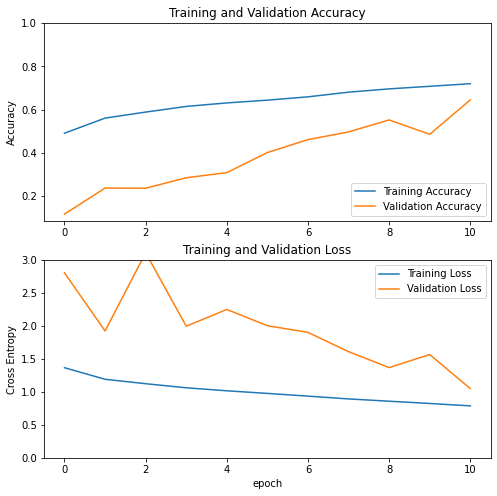

In [56]:
acc = model0.history['accuracy']
val_acc = model0.history['val_accuracy']

loss = model0.history['loss']
val_loss = model0.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [57]:
model.evaluate(testingDataSet)

174/225 [======================>.......] - ETA: 4s - loss: 2.3898 - accuracy: 0.1311

KeyboardInterrupt: 

Fine Tuning

In [58]:
model.trainable = True

In [59]:
len(model.layers)

162

In [60]:
fineTune = 50

for layer in model.layers[:fineTune]:
    layer.trainable = False

In [61]:
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=["accuracy"])

In [62]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [63]:
history1 = model.fit(trainingDataSet, epochs=20, initial_epoch=model0.epoch[-1], validation_data=valDataSet)

Epoch 11/20
898/898 [==============================] - 155s 170ms/step - loss: 0.7926 - accuracy: 0.7202 - val_loss: 0.8224 - val_accuracy: 0.7116
Epoch 12/20
898/898 [==============================] - 153s 170ms/step - loss: 0.7216 - accuracy: 0.7489 - val_loss: 1.0105 - val_accuracy: 0.6574
Epoch 13/20
898/898 [==============================] - 159s 177ms/step - loss: 0.6759 - accuracy: 0.7681 - val_loss: 0.8409 - val_accuracy: 0.6972
Epoch 14/20
898/898 [==============================] - 156s 174ms/step - loss: 0.6376 - accuracy: 0.7834 - val_loss: 0.7264 - val_accuracy: 0.7443
Epoch 15/20
898/898 [==============================] - 156s 174ms/step - loss: 0.5946 - accuracy: 0.7991 - val_loss: 0.7506 - val_accuracy: 0.7405
Epoch 16/20
898/898 [==============================] - 154s 171ms/step - loss: 0.5575 - accuracy: 0.8123 - val_loss: 1.0025 - val_accuracy: 0.6988
Epoch 17/20
898/898 [==============================] - 157s 175ms/step - loss: 0.5199 - accuracy: 0.8282 - val_loss: 0

In [69]:
history1.evaluate(testingDataSet)

AttributeError: 'History' object has no attribute 'evaluate'

In [70]:
fineTune = 90

for layer in model.layers[:fineTune]:
    layer.trainable = False

In [66]:
# model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=["accuracy"])

In [71]:
history1 = model.fit(trainingDataSet, epochs=25, initial_epoch=history1.epoch[-1], validation_data=valDataSet)

Epoch 20/25
898/898 [==============================] - 150s 167ms/step - loss: 0.3983 - accuracy: 0.8737 - val_loss: 0.5147 - val_accuracy: 0.8300
Epoch 21/25
898/898 [==============================] - 148s 165ms/step - loss: 0.3671 - accuracy: 0.8864 - val_loss: 0.6424 - val_accuracy: 0.7915
Epoch 22/25
898/898 [==============================] - 145s 162ms/step - loss: 0.3592 - accuracy: 0.8888 - val_loss: 0.6106 - val_accuracy: 0.8090
Epoch 23/25
898/898 [==============================] - 154s 172ms/step - loss: 0.3265 - accuracy: 0.9012 - val_loss: 0.5422 - val_accuracy: 0.8252
Epoch 24/25
898/898 [==============================] - 143s 159ms/step - loss: 0.3157 - accuracy: 0.9034 - val_loss: 0.6079 - val_accuracy: 0.8115
Epoch 25/25
898/898 [==============================] - 143s 159ms/step - loss: 0.2998 - accuracy: 0.9077 - val_loss: 0.3643 - val_accuracy: 0.8809


In [74]:
model.evaluate(testingDataSet)

 91/225 [===========>..................] - ETA: 12s - loss: 2.1815 - accuracy: 0.1312

KeyboardInterrupt: 

In [75]:
model.save("Model/V1")

INFO:tensorflow:Assets written to: Model/V1\assets


In [ ]:
# model1 = tf.keras.models.load_model("Model/V0")

In [ ]:
# model1.evaluate(testingDataSet)

225/225 [==============================] - 19s 79ms/step - loss: 2.2539 - accuracy: 0.1335


[2.253906488418579, 0.13346335291862488]